In [1]:
import os
import sys
import datetime
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from ir_dataset import VisualizationHelper
from ir_dataset import IRDataSet

# Experiments with the new data

In [2]:
# Initialize some params for nice rendering
VisualizationHelper.initialize_params()
# load data set
data = IRDataSet()

In [3]:
def extract_raw_frames_only(sequence):
    return [entry[4] for entry in sequence]

In [4]:
# Gives us a generator for arrays of tuples. Each tuple contains the processed frame, the raw frame and some metadata.
new_sequences = data.get_raw_sequences_in_range(
    start=datetime.datetime(2019, 10, 24, 17, 50),
    end=datetime.datetime(2019, 10, 24, 17, 53),
    sensor=42
)

Let's start by looking at a few sequences. We do that by loading three sequences. Each sequence contains some meta data but for visualizing the sequence we're only interested in the raw frames. We utilize the helper function `extract_raw_frames_only` which extraces the fourth element of each tuple in the array. Finally we can turn the arrays of frames into videos using  `VisualizationHelper.sequence_to_video`.

In [5]:
some_sequences = [next(new_sequences) for i in range(10)]
raw_sequences = [extract_raw_frames_only(sequence) for sequence in some_sequences]
animations = [VisualizationHelper.sequence_to_video(sequence) for sequence in raw_sequences[:3]]
for animation in animations:
    display(HTML(animation))

## Observations

- the image is quite noisy
- on the left side the pedestrians are warmer than the sidewalk, on the right side they are colder
- there are checkerboard motion artifacts
- pedestrians sometimes like to just stand around (see third sequence)
- contrast in the middle of the image is low

# Ideas

- first denoise the image
  - maybe some kind of PCA Noise removal?
- then do some clever background subtraction
  - needs to avoid burning artifacts since people like to stand around for quite a while
  - needs to handle different temparature differences (winter vs. summer, low constrast vs. high constrast)

## Denoising

Let's try the PCA idea

In [6]:
from sklearn.decomposition import PCA

In [7]:
long_sequence_list = data.get_raw_sequences_in_range(
    start=datetime.datetime(2019, 10, 24, 17, 30),
    end=datetime.datetime(2019, 10, 24, 17, 35),
    sensor=42
)
long_raw_sequence_list = [extract_raw_frames_only(sequence) for sequence in long_sequence_list]
sequence = np.array(long_raw_sequence_list).reshape(len(long_raw_sequence_list)*100, 24, 32)
sequence.shape

(1800, 24, 32)

In [8]:
# Apply checkerboard reduction first

import cv2
element = np.array(([0.0, 0.125, 0.0], [0.125, 0.5, 0.125], [0.0, 0.125, 0.0]))
vector_filter = np.vectorize(lambda frame: cv2.filter2D(frame, -1, element), signature='(m,n)->(m,n)')
filtered_sequence = vector_filter(sequence).reshape(sequence.shape[0], -1)
video = VisualizationHelper.sequence_to_video(filtered_sequence[700:800].reshape((100,24,32)))
HTML(video)

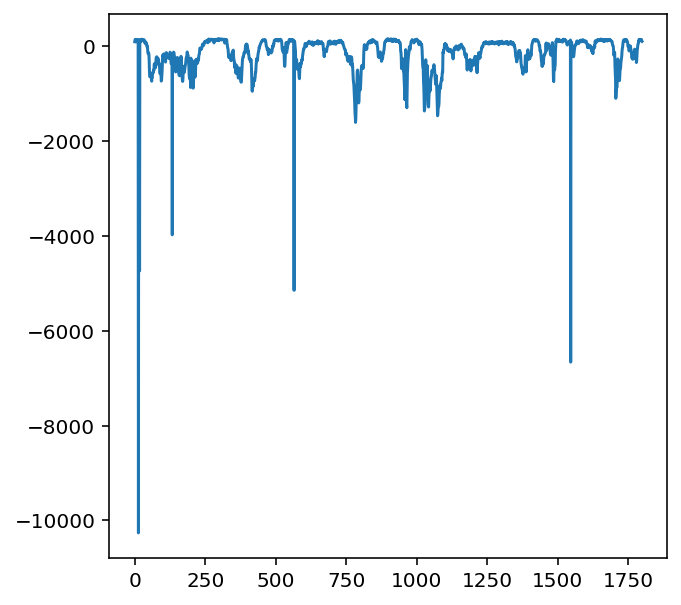

In [9]:
# First PCA to detect anomalies
# (detect onlikely frames and replace by previous frame)

pca = PCA(n_components=10)
short = np.array(filtered_sequence)
pca.fit(filtered_sequence)

# Plot log likelihoods
scores = pca.score_samples(short)
plt.figure(0)
plt.plot(np.arange(short.shape[0]), scores)

for score, (i, frame) in zip(scores, enumerate(short)):
    if score < -2000:
        short[i] = short[i-1]

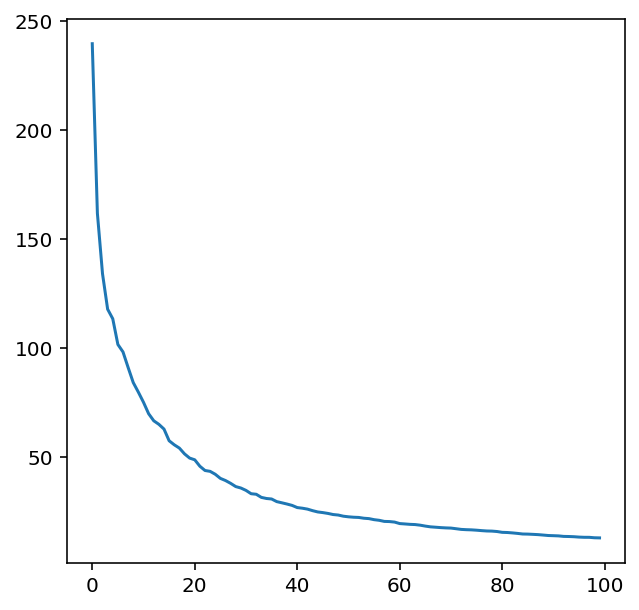

In [10]:
# Second PCA to reduce noise by removing small eigenvectors
pca = PCA(n_components=100)
pca.fit(short)

# Plot sigular values to roughly estimate number of needed components
singular_values = pca.singular_values_
plt.figure(1)
plt.plot(np.arange(singular_values.shape[0]), singular_values)

new_sequence = pca.transform(short)
new_sequence = pca.inverse_transform(new_sequence)
new_sequence = new_sequence.reshape((new_sequence.shape[0],24,32))

In [11]:
# Visualize cleaned frames
video_without_anomalies = VisualizationHelper.sequence_to_video(short[700:800].reshape((100,24,32)))
video_pca = VisualizationHelper.sequence_to_video(new_sequence[700:800])
display(HTML(video_without_anomalies))
display(HTML(video_pca))

In [12]:
# Visualize differeces to noisy image and to background
short_reshaped = short[700:800].reshape((100,24,32))

noise_difference = short_reshaped-new_sequence[700:800]
difference = VisualizationHelper.sequence_to_video(noise_difference)
display(HTML(difference))

denoised_difference = np.abs(new_sequence-new_sequence[700])
difference2 = VisualizationHelper.sequence_to_video(denoised_difference[700:800])
display(HTML(difference2))

noisy_difference = np.abs(short_reshaped-short_reshaped[0])
difference3 = VisualizationHelper.sequence_to_video(noisy_difference)
display(HTML(difference3))

**Still noisy :(**

But still: let's try blob detection

In [31]:
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 80
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 10
params.maxArea = 60

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.3

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.3

params.filterByInertia = False

params.blobColor = 255

detector = cv2.SimpleBlobDetector_create(params)

sequence = (np.clip(denoised_difference / 1.5 - 0.2, 0, 1)*255).astype(np.uint8)
kernel = cv2.getGaussianKernel(5, 2) 
sequence = cv2.morphologyEx(sequence, cv2.MORPH_OPEN, kernel)

detection_sequence = detector.detect([frame for frame in sequence[600:800]])

annotated_sequence = [
    cv2.drawKeypoints(im.astype(np.uint8), keypoints, None, (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    for im, keypoints in zip(sequence[600:800], detection_sequence)
]
HTML(VisualizationHelper.sequence_to_video(annotated_sequence))

In [57]:
track_sequence = np.array(sequence)[0:1000]
trackers = []

def is_in_tracker(point, trackers):
    for tracker_entry in trackers:
        box = tracker_entry[2]
        x_check = box[0] <= point.pt[0] and point.pt[0] <= box[0]+box[2]
        y_check = box[1] <= point.pt[1] and point.pt[1] <= box[1]+box[3]
        if x_check and y_check:
            return (True, tracker_entry)
    return (False, None)

def make_tracker(blob):
    tracker = cv2.TrackerCSRT_create()
    roi = (
        blob.pt[0] - blob.size/2,
        blob.pt[1] - blob.size/2,
        blob.size,
        blob.size
    )
    return tracker, roi

def update(frame):
    old = [(entry[2], index) for index, entry in enumerate(trackers) if entry[0]]
    
    # detect blobs
    new_rois = []
    for tracker_entry in trackers:
        tracker = tracker_entry[1]
        enabled = tracker_entry[0]
        if not enabled:
            continue
        try:
            success, new_roi = tracker.update(frame)
            if success:
                tracker_entry[2] = new_roi
                new_rois.append(new_roi)
            else:
                tracker_entry[0] = False
        except:
            pass
    blobs = detector.detect(frame)
    for blob in blobs:
        known, which_tracker = is_in_tracker(blob, trackers)
        x_range = blob.pt[0] >= 3 and blob.pt[0] <= 32-3
        y_range = blob.pt[1] >= 3 and blob.pt[1] <= 24-3
        if not (x_range and y_range):
            continue
        if known:
            if not which_tracker[0]:
                which_tracker[0] = True
                new_roi = (
                    blob.pt[0] - blob.size/2,
                    blob.pt[1] - blob.size/2,
                    blob.size,
                    blob.size
                )
                which_tracker[1].init(frame, new_roi)
                which_tracker[2] = new_roi
        else:
            new_tracker, new_roi = make_tracker(blob)
            new_tracker.init(frame, new_roi)
            trackers.append([True, new_tracker, new_roi])
    
    real_old, real_new = [],[]
    for old_entry, i in old:
        if trackers[i][0]:
            real_old.append(old_entry)
            real_new.append(trackers[i][2])
    
    crossings = check_crossings(real_old, real_new)
    
    return new_rois, crossings

def did_cross(old_roi, new_roi):
    def make_middle(roi):
        return roi[0]+roi[2]/2, roi[1]+roi[3]/2
    
    def check(p1, p2):
        return p1[0] < 16 and p2[0] >= 16
    
    p1 = make_middle(old_roi)
    p2 = make_middle(new_roi)
    
    return check(p1,p2) or check(p2, p1)

def check_crossings(old, new):
    crossings = 0
    for i, e in enumerate(old):
        if did_cross(old[i], new[i]):
            crossings += 1
    return crossings

boxed_sequence = []
total = 0
for i, frame in enumerate(track_sequence):
    if i % 50 == 0:
        print(f'{i} of {len(track_sequence)}')
    objects, crossings = update(frame)
    total += crossings
    for obj in objects:
        cv2.rectangle(frame, (int(obj[0]),int(obj[1]),int(obj[2]),int(obj[3])), 255)
    boxed_sequence.append(frame)

print(total)
HTML(VisualizationHelper.sequence_to_video(boxed_sequence[0:1000]))

0 of 1000
50 of 1000
100 of 1000
150 of 1000
200 of 1000
250 of 1000
300 of 1000
350 of 1000
400 of 1000
450 of 1000
500 of 1000
550 of 1000
600 of 1000
650 of 1000
700 of 1000
750 of 1000
800 of 1000
850 of 1000
900 of 1000
950 of 1000
22
